# Project 7 - Create a model to predict the revenues of potential customers using ANOVA and Linear Regression.

🎯 Goal: Create a model to predict the future revenue of children based on their location, the revenue of their parents and the gini index; in order to target future customers.

## Part 2 - Features Engineering

At that stage, we already have two of the three desired explanatory variables: 
- the average income per country
- the gini index per country

We need now to get the conditionnal probabilities.

#### Get started

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns
import missingno as msno 
from collections import Counter
import scipy.stats as st

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [8]:
# Read the data
inc = pd.read_csv(Path.cwd()/'Raw'/'data-projet7.csv',decimal=",")
gini = pd.read_csv(Path.cwd()/"newgini.csv",index_col=0)
world = pd.read_csv(Path.cwd()/"worldbank.csv",index_col=0)
igm = pd.read_csv(Path.cwd()/'Raw'/'GDIMMay2018.csv',index_col=0)

In [9]:
# Average income of the country
avg_inc = world.groupby(['name']).mean()[['income','gdpppp']].reset_index()
avg_inc.head()

,name,income,gdpppp
0,Albania,2994.829902,7297.0
1,Argentina,5847.884654,13220.0
2,Armenia,1628.382785,5611.0
3,Austria,16637.600204,36193.0
4,Azerbaijan,2357.429023,8101.0


In [10]:
# The Gini index of the country
gini = gini[['name','new_gini']]
gini.head()

,name,new_gini
0,Albania,32.141019
1,Argentina,46.524916
2,Armenia,28.030458
3,Austria,29.532585
4,Azerbaijan,32.903087


In [11]:
# Compile data together
df4 = pd.merge(avg_inc, gini, on='name',how='left')
df4.head()

,name,income,gdpppp,new_gini
0,Albania,2994.829902,7297.0,32.141019
1,Argentina,5847.884654,13220.0,46.524916
2,Armenia,1628.382785,5611.0,28.030458
3,Austria,16637.600204,36193.0,29.532585
4,Azerbaijan,2357.429023,8101.0,32.903087


Therefore, we only lack now the income class of an individual's parents to move forward into the prediction. We suppose here that we associate with each individual a unique class regardless of the number of parents. We are going to simulate this information using a coefficient (specific to each country) measuring a correlation between the income of the individual and the income of his parents. This coefficient will be called the elasticity coefficient or relative IGM in income. It measures the intergenerational income mobility.

#### Intergenerationnal Income Mobility

In [12]:
igm = igm.reset_index()
igm.head()

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1


In [13]:
# Selection
igm = igm[(igm.parent == 'avg') & (igm.IGEincome.isna()== False)][['countryname','year','parent','IGEincome','iso3']]
igm = igm.groupby(['countryname','year','iso3']).mean().reset_index()
igm

,countryname,year,iso3,IGEincome
0,Albania,1970,ALB,0.815874
1,Australia,1960,AUS,0.275000
2,Austria,1960,AUT,0.245267
3,Belarus,1970,BLR,0.342738
4,Belgium,1960,BEL,0.183176
...,...,...,...,...
65,Uganda,1970,UGA,1.029195
66,United Kingdom,1960,GBR,0.480978
67,United States,1960,USA,0.537666
68,Uzbekistan,1970,UZB,0.496763


In [14]:
# How many countries are covered with an IGM value?
igm['countryname'].nunique()

70

Sources for the relative IGM:

- “GDIM. 2018. Global Database on Intergenerational Mobility. Development Research Group, World Bank. Washington, D.C.: World Bank Group.”
- “Narayan, Ambar; Van der Weide, Roy; Cojocaru, Alexandru; Lakner, Christoph; Redaelli, Silvia; Mahler, Daniel Gerszon; Ramasubbaiah, Rakesh Gupta N.; Thewissen, Stefan. 2018. Fair Progress? : Economic Mobility Across Generations Around the World. Equity and Development. Washington, DC: World Bank. https://openknowledge.worldbank.org/handle/10986/28428 License: CC BY 3.0 IGO.

In [15]:
igm.describe()

,year,IGEincome
count,70.000000,70.000000
mean,1965.142857,0.513053
std,5.314148,0.251053
min,1960.000000,0.112876
25%,1960.000000,0.316933
50%,1965.000000,0.457289
75%,1970.000000,0.675343
max,1980.000000,1.095440


<b> The data from the GDIM are relatively old. Perhaps we could adjust/correct them based on the references below. </b>

In [16]:
# Others sources

- Denmark: 0.15
- Norway: 0.17
- Finland: 0.18
- Canada: 0.19
- Netherlands: 0.22
- Sweden: 0.27
- Germany: 0.32
- France: 0.41
- United States: 0.47
- United Kingdom: 0.50

Source: https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf
- Corak (2006) for all countries except the Netherlands

In [17]:
# Get the regions for each country
md = pd.read_csv(Path.cwd()/'Raw'/'Metadata_Country.csv')
md = md[['Country Code','Region']]

In [18]:
# Add the regions
igm = pd.merge(igm,md, left_on = 'iso3',right_on = 'Country Code',how='left')
igm.head()

,countryname,year,iso3,IGEincome,Country Code,Region
0,Albania,1970,ALB,0.815874,ALB,Europe & Central Asia
1,Australia,1960,AUS,0.275000,AUS,East Asia & Pacific
2,Austria,1960,AUT,0.245267,AUT,Europe & Central Asia
3,Belarus,1970,BLR,0.342738,BLR,Europe & Central Asia
4,Belgium,1960,BEL,0.183176,BEL,Europe & Central Asia


In [19]:
igm.Region.unique()

array(['Europe & Central Asia', 'East Asia & Pacific',
       'Latin America & Caribbean', 'North America',
       'Middle East & North Africa', 'Sub-Saharan Africa', 'South Asia',
       nan], dtype=object)

In [20]:
# Add the values from Corak, 2006
igm['newigm'] = np.where((igm.countryname == 'France'),0.41,
                         np.where((igm.countryname == 'Germany'),0.32,
                          np.where((igm.countryname == 'Sweden'),0.27,
                            np.where((igm.countryname == 'Netherlands'),0.22,
                                np.where((igm.countryname == 'Finland'),0.18,
                                    np.where((igm.countryname == 'Norway'),0.17,
                                        np.where((igm.countryname == 'Denmark'),0.15,
                                            np.where((igm.countryname == 'Canada'),0.19,
                                                np.where((igm.countryname == 'United States'),0.47,
                                                    np.where((igm.countryname == 'United Kingdom'),0.50,0))))))))))
igm.head()

,countryname,year,iso3,IGEincome,Country Code,Region,newigm
0,Albania,1970,ALB,0.815874,ALB,Europe & Central Asia,0.0
1,Australia,1960,AUS,0.275000,AUS,East Asia & Pacific,0.0
2,Austria,1960,AUT,0.245267,AUT,Europe & Central Asia,0.0
3,Belarus,1970,BLR,0.342738,BLR,Europe & Central Asia,0.0
4,Belgium,1960,BEL,0.183176,BEL,Europe & Central Asia,0.0


In [21]:
# Add the base values from range
igm['igm'] = np.where(((igm.Region == 'Europe & Central Asia')& (igm.newigm == 0)),0.4,
                np.where(((igm.countryname == 'Australia')|(igm.countryname == 'New Zealand')),0.4,
                   np.where((igm.Region == 'East Asia & Pacific') & (igm.countryname != 'Australia')
                             &(igm.countryname != 'New Zealand'),0.5,
                     np.where((igm.Region == 'Sub-Saharan Africa'),0.66,
                              np.where((igm.Region == 'South Asia'),0.5,
                                       np.where((igm.Region == 'Middle East & North Africa'),0.66,
                                         np.where((igm.Region == 'Latin America & Caribbean'),0.66,       
                    np.where((igm.newigm != 0),igm.newigm,igm.IGEincome))))))))
igm.head()

,countryname,year,iso3,IGEincome,Country Code,Region,newigm,igm
0,Albania,1970,ALB,0.815874,ALB,Europe & Central Asia,0.0,0.4
1,Australia,1960,AUS,0.275000,AUS,East Asia & Pacific,0.0,0.4
2,Austria,1960,AUT,0.245267,AUT,Europe & Central Asia,0.0,0.4
3,Belarus,1970,BLR,0.342738,BLR,Europe & Central Asia,0.0,0.4
4,Belgium,1960,BEL,0.183176,BEL,Europe & Central Asia,0.0,0.4


In [22]:
# Add the max values from range
igm['max_igm'] = np.where(((igm.Region == 'Europe & Central Asia')),0.5,
                np.where(((igm.countryname == 'Australia')|(igm.countryname == 'New Zealand')),0.5,
                   np.where((igm.Region == 'East Asia & Pacific') & (igm.countryname != 'Australia')
                             &(igm.countryname != 'New Zealand'),0.5,
                     np.where((igm.Region == 'Sub-Saharan Africa'),0.66,
                              np.where((igm.Region == 'South Asia'),0.6,
                                       np.where((igm.Region == 'Middle East & North Africa'),0.66,
                                         np.where((igm.Region == 'Latin America & Caribbean'),0.66,0)))))))  
igm.head()

,countryname,year,iso3,IGEincome,Country Code,Region,newigm,igm,max_igm
0,Albania,1970,ALB,0.815874,ALB,Europe & Central Asia,0.0,0.4,0.5
1,Australia,1960,AUS,0.275000,AUS,East Asia & Pacific,0.0,0.4,0.5
2,Austria,1960,AUT,0.245267,AUT,Europe & Central Asia,0.0,0.4,0.5
3,Belarus,1970,BLR,0.342738,BLR,Europe & Central Asia,0.0,0.4,0.5
4,Belgium,1960,BEL,0.183176,BEL,Europe & Central Asia,0.0,0.4,0.5


In [23]:
# Add the min values from range
igm['min_igm'] = np.where(((igm.Region == 'Europe & Central Asia')),0.3,
                np.where(((igm.countryname == 'Australia')|(igm.countryname == 'New Zealand')),0.3,
                   np.where((igm.Region == 'East Asia & Pacific') & (igm.countryname != 'Australia')
                             &(igm.countryname != 'New Zealand'),0.6,
                     np.where((igm.Region == 'Sub-Saharan Africa'),0.9,
                              np.where((igm.Region == 'South Asia'),0.4,
                                       np.where((igm.Region == 'Middle East & North Africa'),0.9,
                                         np.where((igm.Region == 'Latin America & Caribbean'),0.9,0))))))) 
igm.head()

,countryname,year,iso3,IGEincome,Country Code,Region,newigm,igm,max_igm,min_igm
0,Albania,1970,ALB,0.815874,ALB,Europe & Central Asia,0.0,0.4,0.5,0.3
1,Australia,1960,AUS,0.275000,AUS,East Asia & Pacific,0.0,0.4,0.5,0.3
2,Austria,1960,AUT,0.245267,AUT,Europe & Central Asia,0.0,0.4,0.5,0.3
3,Belarus,1970,BLR,0.342738,BLR,Europe & Central Asia,0.0,0.4,0.5,0.3
4,Belgium,1960,BEL,0.183176,BEL,Europe & Central Asia,0.0,0.4,0.5,0.3


In [24]:
# Take only the relevant columns
igm = igm[['countryname','IGEincome','igm','max_igm','min_igm']]
# Round the IGEincome
igm['IGEincome'] = igm['IGEincome'].round(2)
igm.head(10)

,countryname,IGEincome,igm,max_igm,min_igm
0,Albania,0.82,0.40,0.50,0.3
1,Australia,0.28,0.40,0.50,0.3
2,Austria,0.25,0.40,0.50,0.3
3,Belarus,0.34,0.40,0.50,0.3
4,Belgium,0.18,0.40,0.50,0.3
5,Bolivia,0.87,0.66,0.66,0.9
6,Bosnia and Herzegovina,0.83,0.40,0.50,0.3
7,Brazil,0.64,0.66,0.66,0.9
8,Canada,0.27,0.19,0.00,0.0
9,Chile,0.57,0.66,0.66,0.9


For the countries below, I suggest we keep the data from Corak 2006 as they are more recent:
- Denmark, Norway, Finland, Canada, Netherlands, Sweden, Germany, France, United States, United Kingdom.

For the other countries, I suggest that when the IGE is:
- higher than the max, we hold the max value
- lower than the min, we hold the min value
- in between the min and max, we hold the IGE value.

In [25]:
# Define the intergenerationnal income mobility value for each country
igm['pj'] = np.where((igm.countryname.isin(['Denmark', 'Norway', 'Finland', 'Canada', 'Netherlands', 'Sweden', 
                                            'Germany', 'France', 'United States', 'United Kingdom'])),igm.igm,
                      np.where((igm.IGEincome < igm.min_igm),igm.min_igm, np.where((igm.IGEincome > igm.max_igm),igm.max_igm,igm.IGEincome)))
igm.head()

,countryname,IGEincome,igm,max_igm,min_igm,pj
0,Albania,0.82,0.4,0.5,0.3,0.50
1,Australia,0.28,0.4,0.5,0.3,0.30
2,Austria,0.25,0.4,0.5,0.3,0.30
3,Belarus,0.34,0.4,0.5,0.3,0.34
4,Belgium,0.18,0.4,0.5,0.3,0.30


In [26]:
# Compile all together in a dataset
df4 = pd.merge(df4, igm[['countryname','pj']], left_on='name',right_on='countryname',how='inner')
df4.drop('countryname',axis=1,inplace=True)
df4.head()

,name,income,gdpppp,new_gini,pj
0,Albania,2994.829902,7297.0,32.141019,0.50
1,Austria,16637.600204,36193.0,29.532585,0.30
2,Belarus,3921.163534,11651.0,28.329229,0.34
3,Belgium,15024.614176,33561.0,30.157968,0.30
4,Bosnia and Herzegovina,6334.687311,7472.0,37.182986,0.50


In [27]:
# Get the IGEincome of France
fr = df4[df4.name == 'France']
fr.head()

,name,income,gdpppp,new_gini,pj
15,France,18309.407545,30357.0,34.563984,0.41


In [28]:
# Countries with low IGEincome
df4[df4.pj <= 0.2]

,name,income,gdpppp,new_gini,pj
6,Canada,23739.640518,35895.0,36.655324,0.19
12,Denmark,17043.146491,34130.0,27.710015,0.15
14,Finland,16306.330495,33626.0,29.391800,0.18
38,Norway,22483.375020,49070.0,28.014664,0.17


In [29]:
# Countries with high IGEincome
df4[df4.pj >= 0.9]

,name,income,gdpppp,new_gini,pj
5,Brazil,4807.484594,9559.00000,55.890464,0.9
7,Chile,7051.609966,13390.00000,54.611472,0.9
17,Ghana,736.602529,1380.11820,44.315701,0.9
20,Guinea,696.012013,977.00000,41.217855,0.9
25,Jordan,3048.630976,5082.93160,35.418291,0.9
27,Kenya,519.320032,1429.00000,31.576919,0.9
29,Madagascar,345.237074,950.00000,45.595122,0.9
30,Malawi,914.265402,728.81158,46.673348,0.9
32,Mali,681.075039,929.52966,34.678231,0.9
37,Nigeria,691.855363,1946.00000,48.344469,0.9


These tables indicate large differences between the various countries. 
- The earnings elasticity in Denmark, Norway, Finland and Canada is less than 0.2, implying a high degree of mobility across generations. 
- The earnings elasticity in France, the United States and the United Kingdom is greater than 0.4, indicating a lower degree of mobility. 
- The value for the Netherlands (0.22) suggests an average income mobility.

#### Generate child's incomes based on parent's income and IGE income mobility

1. Generate a large number n of realizations of a variable that we will call ln_Y_parent, according to a normal distribution.
2. Generate n realizations of the error term epsilon, according to a normal distribution with mean 0 and standard deviation 1.
3. For a given value of pj (eg 0.9), calculate y_child

In [30]:
def generate_incomes(data):
    n = 1000*100
    pj = data['pj'].values
    
    parent_incomes = st.norm(0,1).rvs(size=n,random_state = 42) # 1. generates a random variable following a normal distribution
    residuals = st.norm(0,1).rvs(size=n,random_state = 10) # 2. generates the error term epsilon
    
    y_child = np.exp(pj*parent_incomes + residuals)
    y_parent = np.exp(parent_incomes)
    
    df = pd.DataFrame({'y_child':y_child, 'y_parent':y_parent})

    return df

In [31]:
income = df4.groupby('name').apply(generate_incomes).reset_index().drop('level_1',axis=1)
income.head()

,name,y_child,y_parent
0,Albania,4.854682,1.643313
1,Albania,1.908174,0.870868
2,Albania,0.294771,1.911118
3,Albania,2.123639,4.586099
4,Albania,1.655759,0.791240


#### Calculate class of incomes for both - parents and child

4. For each of the individuals generated, calculate the income class c_child as well as the income class of its parents c_parents, from y_child and y_parents.

In [102]:
def quantiles(l, nb_quantiles):

    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}

    return pd.Series([q_dict[e] for e in l])

In [103]:
def compute_quantiles(data):
    
    y_child = np.array(data['y_child'])
    y_parent = np.array(data['y_parent'])
    nb_quantiles = 100

    y_child = pd.Series(y_child)
    y_parent = pd.Series(y_parent)
    
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parent, nb_quantiles)
    
    sample = pd.concat([y_child, y_parent, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parent", "c_i_child","c_i_parent"]

    return sample

In [104]:
quant = income.groupby('name').apply(compute_quantiles).reset_index().drop('level_1',axis=1)
quant.head()

,name,y_child,y_parent,c_i_child,c_i_parent
0,Albania,4.854682,1.643313,93,70
1,Albania,1.908174,0.870868,72,45
2,Albania,0.294771,1.911118,14,75
3,Albania,2.123639,4.586099,76,94
4,Albania,1.655759,0.791240,68,41


#### Estimate conditional distribution of child's class based on parent's class

5. From this last information, estimate for each c_child the conditional distribution of c_parent.

In [105]:
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()

    if total == 0 :
        return [0] * nb_quantiles

    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]

    return distrib   

In [106]:
# Calculate the conditional distribution: probability of child's class to occur knowing parent's class
def conditional_distributions(sample):
    nb_quantiles = 100
    
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]

    mat = []

    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]

    return np.array(mat)

In [107]:
# Calculate the conditional distribution for each rows
cd = quant.groupby('name').apply(conditional_distributions)

In [108]:
# Convert the series into a dataframe
cd_df = pd.DataFrame(cd) 
cd_df = cd_df.reset_index()
cd_df.rename(columns={cd_df.columns[1]: "cond"},inplace=True)

# Compile data together
cd_f = pd.merge(df4, cd_df, on = ['name'], how = 'inner')
cd_f.head()

,name,income,gdpppp,new_gini,pj,cond
0,Albania,2994.829902,7297.0,32.141019,0.50,"[[0.12, 0.06, 0.047, 0.039, 0.03, 0.039, 0.035..."
1,Austria,16637.600204,36193.0,29.532585,0.30,"[[0.065, 0.028, 0.025, 0.027, 0.02, 0.03, 0.02..."
2,Belarus,3921.163534,11651.0,28.329229,0.34,"[[0.072, 0.037, 0.031, 0.03, 0.024, 0.031, 0.0..."
3,Belgium,15024.614176,33561.0,30.157968,0.30,"[[0.065, 0.028, 0.025, 0.027, 0.02, 0.03, 0.02..."
4,Bosnia and Herzegovina,6334.687311,7472.0,37.182986,0.50,"[[0.12, 0.06, 0.047, 0.039, 0.03, 0.039, 0.035..."


#### Visualizing the conditional distributions for 3 countries.

6. Plot the conditional distributions

In [109]:
# Function to plot the conditionnal distributions
def plot_conditional_distributions(p, data, nb_quantiles):
    plt.figure(figsize=(15,8))
    
    cd = data[['cond']].iloc[0][0]

    # to plot in stack-bar mode
    cumul = np.array([0] * nb_quantiles)

    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles,0 ,1])
    plt.title("p=" + str(p))
    #plt.legend()
    plt.xlabel("parent's quantile")
    plt.ylabel("probability of the child's quantile")
    plt.show()

In [110]:
# Pick 3 countries as examples: France, Denmark and Panama
fr = cd_f[cd_f.name == 'France']
den = cd_f[cd_f.name == 'Denmark']
pan = cd_f[cd_f.name == 'Panama']

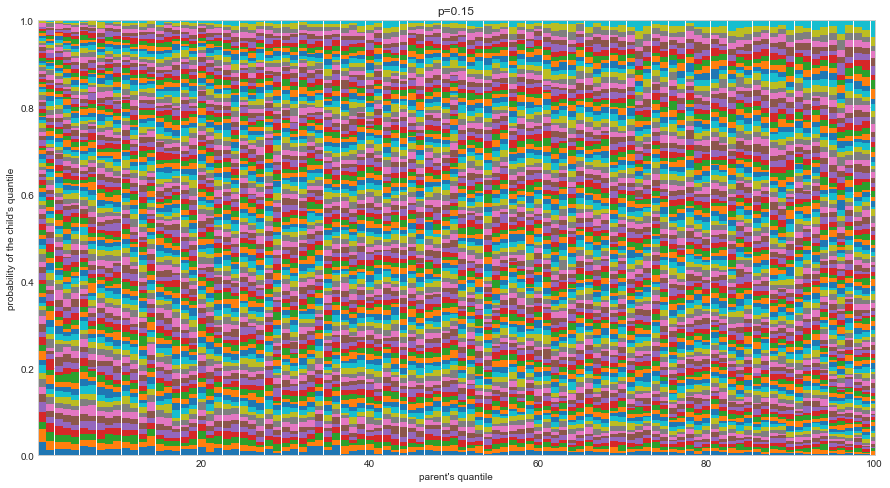

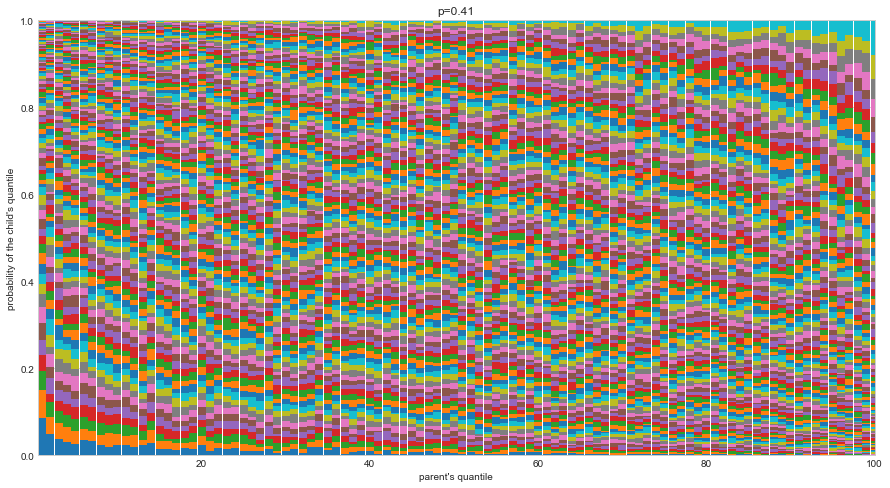

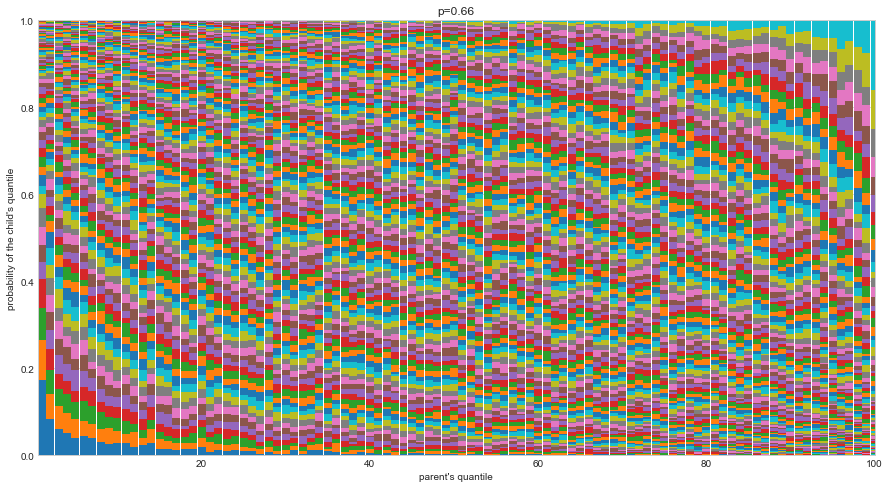

In [111]:
# Plot the conditional distribution for the selected countries to check the validity of our code
plot_conditional_distributions(den['pj'].values[0],den,100)
plot_conditional_distributions(fr['pj'].values[0],fr,100)
plot_conditional_distributions(pan['pj'].values[0],pan,100)

On the plot of Panama, which has a high IGEincome value (pj = 0.9), we can see that the earnings of (adult) children depend more on the  income of their parents (the probability of the child's quantile vary more strongly with the parent's quantile) than for example, in country like Denmark (the probability of the child's quantile do not vary a lot with the parent's quantile). It means, that a child born in a family with low revenue in Panama, has a higher probability to also have low revenue when he will be adult.

In [112]:
# Save csv
quant.to_csv(Path.cwd()/'quantile.csv')
df2.to_csv(Path.cwd()/'worldbank.csv')
df4.to_csv(Path.cwd()/'worldbank_avg.csv')